<img src="images/logo_city.png" align="right" width="20%">

# Training A Graph State Prediction Network (GSPNet)

This notebook is a prototype on how to train a graph state prediction network using CNN and LSTM.
The content is devided into __3__ parts:

1. Data preprocessing
2. Model building, Training and Tuning
3. Prediction and per demand modifacation

The model is built with [PyTorch](https://pytorch.org/).

## Part 1: Data Preprocessing

### 1. Import necessary libraries:

We will use pandas and numpy as main data examine and cleansing util and use dask to handle parallel computing cases

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy
import dask
import time
import psycopg2
import warnings
import re
import torch
from PIL import Image
from IPython.display import display
from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


<br></br>
<br></br>
We'll first, use a small sample data (approximately 1 million rows) and see a few rows of it:

In [2]:
# Load already cleaned data sample using plain pandas
t1 = time.time()
table = pd.read_csv('dataset/nytaxi_yellow_2017_apr.csv')
print(f'Load time is {time.time() - t1 :2f}.')
table.head()

Load time is 42.193149.


tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
0  46266925  2017-04-01 00:00:00   2017-04-01 00:15:07           158   
1  46266926  2017-04-01 00:00:00   2017-04-01 00:16:23            87   
2  46266928  2017-04-01 00:00:01   2017-04-01 00:37:05           230   
3  46266929  2017-04-01 00:00:01   2017-04-01 00:02:56           142   
4  46266930  2017-04-01 00:00:01   2017-04-01 00:07:28           170   

   dolocationid  trip_distance  passenger_count  total_amount trip_time  \
0           113            1.8                1         11.80  00:15:07   
1           158            3.7                3         15.80  00:16:23   
2             4            3.3                2         29.75  00:37:04   
3           143            0.7                1          5.80  00:02:55   
4           263            2.2                1         12.25  00:07:27   

   trip_avg_speed  trip_time_sec  
0        7.144432            907  
1       13.550356            983  
2        5.341727           2224  
3       14.400000            175  
4       17.718121            447

### 2. First sight of the data

Let's see the the type of columns and some basic statistics of the sample data:

In [3]:
# column data types
table.dtypes

tripid                     int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
pulocationid               int64
dolocationid               int64
trip_distance            float64
passenger_count            int64
total_amount             float64
trip_time                 object
trip_avg_speed           float64
trip_time_sec              int64
dtype: object

In [4]:
# rows and columns
table.shape

(9976305, 11)

In [5]:
# basic statistics
table.describe()

tripid  pulocationid  dolocationid  trip_distance  \
count  9.976305e+06  9.976305e+06  9.976305e+06   9.976305e+06   
mean   5.129000e+07  1.625606e+02  1.603451e+02   2.974855e+00   
std    2.900027e+06  6.682011e+01  7.079396e+01   3.765064e+00   
min    4.626692e+07  1.000000e+00  1.000000e+00   1.000000e-02   
25%    4.877799e+07  1.140000e+02  1.070000e+02   1.000000e+00   
50%    5.129070e+07  1.620000e+02  1.620000e+02   1.680000e+00   
75%    5.380126e+07  2.330000e+02  2.330000e+02   3.100000e+00   
max    5.631311e+07  2.650000e+02  2.650000e+02   3.080200e+02   

       passenger_count  total_amount  trip_avg_speed  trip_time_sec  
count     9.976305e+06  9.976305e+06    9.976305e+06   9.976305e+06  
mean      1.628855e+00  1.623789e+01    1.343366e+01   9.917470e+02  
std       1.265034e+00  6.443697e+01    1.610219e+02   3.382931e+03  
min       0.000000e+00 -3.983000e+02    4.171446e-04   1.000000e+00  
25%       1.000000e+00  8.750000e+00    7.452559e+00   4.010000e+02  
50%       1.000000e+00  1.180000e+01    1.004255e+01   6.710000e+02  
75%       2.000000e+00  1.780000e+01    1.362637e+01   1.101000e+03  
max       9.000000e+00  1.986444e+05    7.704000e+04   1.730178e+06

The columns we will use are: **tpep_pickup_datetime, pulocationid, tpep_dropoff_datetime, dolocationid.**
These information are used to generate graphs that are used to discribe the general traffic state of New York.

Notice currently the **tpep_pickup_datetime** and **tpep_dropoff_datetime** are of type `object`:

In [6]:
table.loc[:,['tpep_pickup_datetime', 'tpep_dropoff_datetime']].head()

tpep_pickup_datetime tpep_dropoff_datetime
0  2017-04-01 00:00:00   2017-04-01 00:15:07
1  2017-04-01 00:00:00   2017-04-01 00:16:23
2  2017-04-01 00:00:01   2017-04-01 00:37:05
3  2017-04-01 00:00:01   2017-04-01 00:02:56
4  2017-04-01 00:00:01   2017-04-01 00:07:28

In order to do **time slice** later, these two feilds must be sorted in chronological mananer, first by `tpep_pickup_datetime` and then by `tpep_dropoff_datetime`, as follows:

In [7]:
# pick first 10 rows
# not supported for dask DataFrame
table.sort_values(by=['tpep_pickup_datetime', 'tpep_dropoff_datetime']).head(10)

tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
0   46266925  2017-04-01 00:00:00   2017-04-01 00:15:07           158   
1   46266926  2017-04-01 00:00:00   2017-04-01 00:16:23            87   
6   46266932  2017-04-01 00:00:01   2017-04-01 00:02:40           166   
3   46266929  2017-04-01 00:00:01   2017-04-01 00:02:56           142   
15  46266941  2017-04-01 00:00:01   2017-04-01 00:06:09           230   
4   46266930  2017-04-01 00:00:01   2017-04-01 00:07:28           170   
5   46266931  2017-04-01 00:00:01   2017-04-01 00:08:30           100   
7   46266933  2017-04-01 00:00:01   2017-04-01 00:10:20           113   
13  46266939  2017-04-01 00:00:01   2017-04-01 00:31:14           132   
2   46266928  2017-04-01 00:00:01   2017-04-01 00:37:05           230   

    dolocationid  trip_distance  passenger_count  total_amount trip_time  \
0            113           1.80                1         11.80  00:15:07   
1            158           3.70                3         15.80  00:16:23   
6            166           0.40                1          5.30  00:02:39   
3            143           0.70                1          5.80  00:02:55   
15           142           1.06                6          9.36  00:06:08   
4            263           2.20                1         12.25  00:07:27   
5             48           0.70                1          9.95  00:08:29   
7             68           1.23                1         10.30  00:10:19   
13           234          18.21                1         73.20  00:31:13   
2              4           3.30                2         29.75  00:37:04   

    trip_avg_speed  trip_time_sec  
0         7.144432            907  
1        13.550356            983  
6         9.056604            159  
3        14.400000            175  
15       10.369565            368  
4        17.718121            447  
5         4.950884            509  
7         7.153473            619  
13       35.000534           1873  
2         5.341727           2224

We can see from above that the taxi trips are nicely sorted according to **time**. What we need to do is convert this tabular date into graphs that described by **adjacency matrice**.

First, let's see what are `pulocationid` and `dolocationid`:

<img src="images/map.jpg" align="center" width="60%">

They are code number for a district in Manhattan, New York. We will mainly describe the traffic state and prediction at **this** level.

### 3. Time slicing

Now we've done a very superficial exploration of the data. It's time to convert the tabular data to graphs that are to be fed into our neural network model.

The first problem is, **how to decide a feasible time interval?**

Of course, the time interval should be a varaible that is to be selected **per need. However,** it is a reasonable thinking to let a time interval (i.e. a **snapshot**) to contain as many as **complete trip** as possible. See the diagram below:

<img src="images/snapshot.png" align="center" width="70%">

#### **If the time interval is too small**:

The majority of the matrices will be very sparse or even completely blank.

#### If the time interval is too big:

Then information about trips will be densely squeezed into one matrix and a lot of details on changes along time will be lost.

Thus, it is important to choose time interval wisely. Let's look at the data again:

In [8]:
table.loc[:,['trip_distance', 'trip_time_sec', 'trip_avg_speed']].describe()

trip_distance  trip_time_sec  trip_avg_speed
count   9.976305e+06   9.976305e+06    9.976305e+06
mean    2.974855e+00   9.917470e+02    1.343366e+01
std     3.765064e+00   3.382931e+03    1.610219e+02
min     1.000000e-02   1.000000e+00    4.171446e-04
25%     1.000000e+00   4.010000e+02    7.452559e+00
50%     1.680000e+00   6.710000e+02    1.004255e+01
75%     3.100000e+00   1.101000e+03    1.362637e+01
max     3.080200e+02   1.730178e+06    7.704000e+04

The an average trip lasts for roughly 900 seconds, which is **15 minutes**.

The median(i.e. 50% percentile) is roughly 600 seconds, which is **10 minutes**.

Let's plot the distribution of column `trip_time_sec` to have a better intuition:

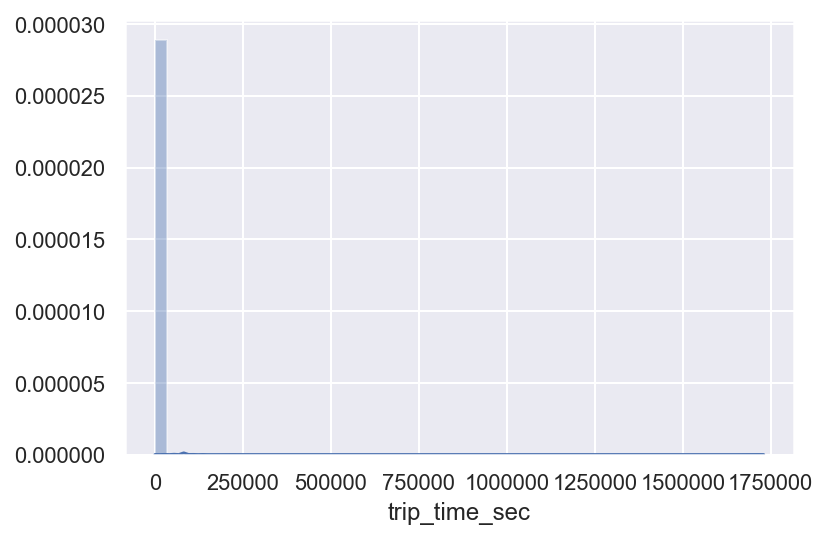

In [9]:
warnings.simplefilter('ignore')
sns.set(color_codes=True)
sns.distplot(table.loc[:,'trip_time_sec']);

It seems that the trips are mostly concentrated in a shorter time range, while some outliers may significantly biased the average.

Let's see how how many trips are longer than 30 minutes (1800 secs):

In [10]:
# rows with column 'trip_time_sec' value larger than 1800 divided by total number of rows
table.loc[table['trip_time_sec'] > 1800].shape[0] / table.shape[0]

0.08742154535171087

Dask version of above cell:

There are **95%** of the trips last shorter than 30 minutes, let's plot distribution at this range:

In [11]:
# distribution of 95% trip data in time duration
temp = table.loc[table['trip_time_sec'] <= 1800]
sns.distplot(temp.loc[:,'trip_time_sec']);

In [12]:
# statistics on the 95% data
temp.loc[:,['trip_distance', 'trip_time_sec', 'trip_avg_speed']].describe()

trip_distance  trip_time_sec  trip_avg_speed
count   9.104161e+06   9.104161e+06    9.104161e+06
mean    2.199769e+00   7.006356e+02    1.325340e+01
std     2.199440e+00   4.054301e+02    1.685376e+02
min     1.000000e-02   1.000000e+00    2.044293e-02
25%     9.400000e-01   3.800000e+02    7.377049e+00
50%     1.510000e+00   6.190000e+02    9.839650e+00
75%     2.580000e+00   9.560000e+02    1.310680e+01
max     1.103000e+02   1.800000e+03    7.704000e+04

In [13]:
# value and their appearance
pd.DataFrame(temp.loc[:,'trip_time_sec'].value_counts().sort_values())

trip_time_sec
1              178
16             354
17             375
26             377
22             379
20             398
18             403
29             407
36             409
24             410
27             414
32             417
14             419
19             421
28             423
21             425
13             429
34             436
23             446
12             450
33             452
31             455
30             462
25             465
11             471
37             477
38             484
15             497
39             505
10             517
..             ...
352          10235
459          10249
337          10250
376          10252
343          10264
307          10271
363          10273
344          10286
347          10290
354          10294
390          10298
439          10304
479          10316
404          10336
438          10340
328          10341
383          10351
449          10357
374          10358
384          10384
338          10394
394          10486
408          10494
418          10502
348          10512
378          10514
358          10611
368          10621
398          10657
388          10690

[1800 rows x 1 columns]

More than 50% of the trips have trip time between 6 to 15 minutes, with a median of 10 minutes.

#### As a result, we primarily decide to use 10 minutes as time interval.

### 4. From tabular data to graph

Since we have decided a time interval, it's time to generate matrices. Basically, the idea is shown as figure below:

<img src="images/matrices.png" align="left" width="85%">

Apart from **outgoin** and **incoming** matrices shown above, an additional **Domestic** matrix is add because 50% of trips last less than the **chosen interval 10 minutes**. Such matrices can be combined into a **Tensor** illustrated as follows:

<img src="images/layers.png" align="center" width="35%">

#### STRICT DEFINITION OF OID layers

+ **F**uture layer
    Condition: 

    1. left bound of interval  <= tpep_pickup_datetime  < right bound of interval
    2. right bound of interval <= tpep_dropoff_datetime


+ **P**ast layer
    Condition: 

    1. left bound of interval  <= tpep_dropoff_datetime  < right bound of interval
    2. tpep_pickup_datetime < left bound of interval


+ **N**ow layer
    Condition: 

    1. left bound of interval  <= tpep_pickup_datetime < tpep_dropoff_datetime  < right bound of interval

### Notice: The PNF layers are redefined and renamed from OID layers.

#### Extract relevant columns:

To generate tensor defined above, **four** key columns are needed.They are `tpep_pickup_datetime`, `tpep_dropoff_datetime`, `pulocationid` and `dolocationid`.

We first extract them from original table:

In [14]:
# draw four needed columns and a id column, then sort according to time.
# the `tripid` column is for the sake of naming.
tensor_gen_f = table.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                      ].sort_values(by=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) # the first sort condition rules
tensor_gen_f.head()

tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
0   46266925  2017-04-01 00:00:00   2017-04-01 00:15:07           158   
1   46266926  2017-04-01 00:00:00   2017-04-01 00:16:23            87   
6   46266932  2017-04-01 00:00:01   2017-04-01 00:02:40           166   
3   46266929  2017-04-01 00:00:01   2017-04-01 00:02:56           142   
15  46266941  2017-04-01 00:00:01   2017-04-01 00:06:09           230   

    dolocationid  
0            113  
1            158  
6            166  
3            143  
15           142

#### Slice the table to sub-tables according to time interval (10 min)

Since the columns are extracted, now it's time to generate tensors.

The dataset is trip data of all yellow taxi cabs in Manhattan area in **January**, 2017.As we are making 10-minute-splices, there will be total:

$$
6 \times 24 \times 31 = 4464 \space slices(i.e. \space snapshots)
$$

Each slice has 3 layers, that is in total

$$
4464 \times 3 = 13392 \space matrices
$$
to be generated. 

First, let's try to generate one image (i.e. a *tensor* with **3** layers).

The time columns need to be converted to pandas timestamp type in order to compare:

In [15]:
# current type is python str
type(tensor_gen_f.iloc[0,1])

str

In [16]:
# convert to timestamp
pd.to_datetime(tensor_gen_f.iloc[0,1])

Timestamp('2017-04-01 00:00:00')

In [17]:
t1 = pd.to_datetime(tensor_gen_f.iloc[0,1]) # 2017-01-01 00:00:00
t2 = pd.to_datetime(tensor_gen_f.iloc[0,2]) # 2017-01-01 00:01:00
t1 < t2 # test if can compare time

True

In [18]:
# apply type cast to all values:
tensor_gen_f['tpep_pickup_datetime'] = pd.to_datetime(tensor_gen_f['tpep_pickup_datetime'])
tensor_gen_f['tpep_dropoff_datetime'] = pd.to_datetime(tensor_gen_f['tpep_dropoff_datetime'])

tensor_gen_f.dtypes

tripid                            int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
pulocationid                      int64
dolocationid                      int64
dtype: object

In [19]:
tensor_gen_f.head()

tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
0   46266925  2017-04-01 00:00:00   2017-04-01 00:15:07           158   
1   46266926  2017-04-01 00:00:00   2017-04-01 00:16:23            87   
6   46266932  2017-04-01 00:00:01   2017-04-01 00:02:40           166   
3   46266929  2017-04-01 00:00:01   2017-04-01 00:02:56           142   
15  46266941  2017-04-01 00:00:01   2017-04-01 00:06:09           230   

    dolocationid  
0            113  
1            158  
6            166  
3            143  
15           142

The interval **boundaries** are fixed when interval is set.

In [20]:
# create intervals
intervals = pd.date_range('2017-04-01 00:00:00', '2017-05-01 00:00:00', freq='10min')
print(len(intervals))
intervals

4321


DatetimeIndex(['2017-04-01 00:00:00', '2017-04-01 00:10:00',
               '2017-04-01 00:20:00', '2017-04-01 00:30:00',
               '2017-04-01 00:40:00', '2017-04-01 00:50:00',
               '2017-04-01 01:00:00', '2017-04-01 01:10:00',
               '2017-04-01 01:20:00', '2017-04-01 01:30:00',
               ...
               '2017-04-30 22:30:00', '2017-04-30 22:40:00',
               '2017-04-30 22:50:00', '2017-04-30 23:00:00',
               '2017-04-30 23:10:00', '2017-04-30 23:20:00',
               '2017-04-30 23:30:00', '2017-04-30 23:40:00',
               '2017-04-30 23:50:00', '2017-05-01 00:00:00'],
              dtype='datetime64[ns]', length=4321, freq='10T')

In [21]:
type(intervals)

pandas.core.indexes.datetimes.DatetimeIndex

**Notice**:

When slicing time interval in such manner, we are assuming the **entire** month is monitored. Under this setting, we do not consider another day as a 'fresh start'.



In [22]:
str(intervals[1])

'2017-04-01 00:10:00'

In [23]:
# First sub table:
first = tensor_gen_f.loc[tensor_gen_f['tpep_pickup_datetime'] < intervals[1]]
print(f'shape is: {first.shape}')
first.head()

shape is: (3092, 5)


tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
0   46266925  2017-04-01 00:00:00   2017-04-01 00:15:07           158   
1   46266926  2017-04-01 00:00:00   2017-04-01 00:16:23            87   
6   46266932  2017-04-01 00:00:01   2017-04-01 00:02:40           166   
3   46266929  2017-04-01 00:00:01   2017-04-01 00:02:56           142   
15  46266941  2017-04-01 00:00:01   2017-04-01 00:06:09           230   

    dolocationid  
0            113  
1            158  
6            166  
3            143  
15           142

In [24]:
# sort to have a clearer look:
first.sort_values(by=['pulocationid', 'dolocationid']).head(20)

tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
3996  46270954  2017-04-01 00:02:16   2017-04-01 00:11:25             4   
6265  46273233  2017-04-01 00:09:34   2017-04-01 00:21:24             4   
4236  46271196  2017-04-01 00:03:01   2017-04-01 00:51:41             4   
4602  46271563  2017-04-01 00:04:09   2017-04-01 00:24:18             4   
3874  46270832  2017-04-01 00:01:48   2017-04-01 00:18:32             4   
4661  46271622  2017-04-01 00:04:22   2017-04-01 00:11:30             4   
5390  46272354  2017-04-01 00:06:43   2017-04-01 00:21:36             4   
5985  46272951  2017-04-01 00:08:35   2017-04-01 00:20:34             4   
5233  46272197  2017-04-01 00:06:13   2017-04-01 00:12:33             4   
4299  46271259  2017-04-01 00:03:13   2017-04-01 00:23:00             4   
4246  46271206  2017-04-01 00:03:03   2017-04-01 00:30:16             4   
4076  46271034  2017-04-01 00:02:29   2017-04-01 00:19:21             4   
6323  46273291  2017-04-01 00:09:46   2017-04-01 00:24:39             4   
6329  46273297  2017-04-01 00:09:47   2017-04-01 00:25:54             4   
157   46267084  2017-04-01 00:00:30   2017-04-01 00:11:45             4   
3696  46270654  2017-04-01 00:01:13   2017-04-01 00:32:15             4   
4031  46270989  2017-04-01 00:02:22   2017-04-01 00:09:19             7   
5721  46272687  2017-04-01 00:07:38   2017-04-01 00:12:17             7   
5034  46271996  2017-04-01 00:05:31   2017-04-01 00:13:47             7   
3684  46270642  2017-04-01 00:01:10   2017-04-01 00:08:08             7   

      dolocationid  
3996            13  
6265            13  
4236            40  
4602            48  
3874            75  
4661            79  
5390           114  
5985           114  
5233           148  
4299           163  
4246           165  
4076           186  
6323           231  
6329           234  
157            249  
3696           265  
4031             7  
5721             7  
5034           223  
3684           226

The `first` will generate Outgoing, Incoming and Domestic layers, that is, 3 matrices of size: 

$$
(number \space of\space zones)\space \times \space (number\space of\space zones)
$$

Let's see the zone numbers:

In [25]:
# Load zone lookup table
zones = pd.read_csv('dataset/taxi_zone_lookup.csv')
print(f'shape is: {zones.shape}')

shape is: (265, 4)


Total 265 zones, indexing from 0 to 264.

Among which, we only care about `Yellow Zone` or `Manhattan` area:

In [26]:
y_zone = zones.loc[zones['Borough'] == 'Manhattan']
print(y_zone.shape)
img_size = y_zone.shape[0]

(69, 4)


Thus, the layers should be matrices of size (69, 69), and each timeslice(snapshot) should be tensors of size (69, 69, 3).

Create the first tensor:

### The key is to use generated intervals to 'catch' trips.

In [38]:
# legacy code, currently in use
left = 1481
right = 1482

# convert dtype for entire table here:
table['tpep_pickup_datetime'] = pd.to_datetime(table['tpep_pickup_datetime'])
table['tpep_dropoff_datetime'] = pd.to_datetime(table['tpep_dropoff_datetime'])

sorted_table = table.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                        ].sort_values(by=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# The condition of making snapshot should be: at least one temporal end of a trip should be within the bounds:
snap = sorted_table.loc[((sorted_table['tpep_pickup_datetime'] >= intervals[left]) &
                        (sorted_table['tpep_pickup_datetime'] < intervals[right])) |
                        ((sorted_table['tpep_dropoff_datetime'] >= intervals[left]) &
                        (sorted_table['tpep_dropoff_datetime'] < intervals[right]))
                        ]
print(f'sorted_table.shape -> {sorted_table.shape}')
print(f'snap.shape -> {snap.shape}')

# temp table to generate F,P,N layers
# No need to sort
temp_snap = snap.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                    ]


# Use the interval to 'catch' trips.
f_flayer = temp_snap.loc[(temp_snap['tpep_pickup_datetime'] < intervals[right]) &
                            (temp_snap['tpep_pickup_datetime'] >= intervals[left]) &
                            (temp_snap['tpep_dropoff_datetime'] >= intervals[right])
                           ]

f_player = temp_snap.loc[(temp_snap['tpep_pickup_datetime'] < intervals[left]) &
                            (temp_snap['tpep_dropoff_datetime'] >= intervals[left]) &
                            (temp_snap['tpep_dropoff_datetime'] < intervals[right])
                           ]

f_nlayer = temp_snap.loc[(temp_snap['tpep_pickup_datetime'] >= intervals[left]) &
                            (temp_snap['tpep_dropoff_datetime'] < intervals[right])
                           ]

print(f'f_flayer.shape: {f_flayer.shape}')
print(f'f_player.shape: {f_player.shape}') # There will be no incoming trips for the first snapshot.
print(f'f_nlayer.shape: {f_nlayer.shape}')

# Their shape should be the same
assert temp_snap.shape[0] == f_flayer.shape[0] + f_player.shape[0] + f_nlayer.shape[0]

sorted_table.shape -> (9976305, 5)
snap.shape -> (3020, 5)
f_flayer.shape: (1241, 5)
f_player.shape: (1270, 5)
f_nlayer.shape: (509, 5)


### Wrap the above procedure into a function for later use:

In [39]:
def gen_snap_layers(table, bound):
    '''
    Generate Past layer, Now layer and Future layer for one snapshot.
    Params:
        table:
        bounds:
    Return:
        PNF layers, a list.
    '''
    # left bound and right bound of time interval
    assert type(bound) == tuple
    left = bound[0]
    right = bound[1]
    
    print(left, right)

    sorted_table = table.loc[:, ['tripid',
                                 'tpep_pickup_datetime',
                                 'tpep_dropoff_datetime',
                                 'pulocationid',
                                 'dolocationid']].sort_values(by=['tpep_pickup_datetime',
                                                                  'tpep_dropoff_datetime'])

    # The condition of making snapshot should be:
    # at least one temporal end of a trip should be within the bounds:
    snap = sorted_table.loc[
        ((sorted_table['tpep_pickup_datetime'] >= left) &
         (sorted_table['tpep_pickup_datetime'] < right)) |
        ((sorted_table['tpep_dropoff_datetime'] >= left) &
         (sorted_table['tpep_dropoff_datetime'] < right))]

    # temp table to generate F,P,N layers
    # keep snap intact
    temp_snap = snap.loc[:, ['tripid',
                             'tpep_pickup_datetime',
                             'tpep_dropoff_datetime',
                             'pulocationid',
                             'dolocationid']]

    # Use the interval to 'catch' corresponding trips.
    # future layer
    f_layer = temp_snap.loc[(temp_snap['tpep_pickup_datetime'] < right) &
                             (temp_snap['tpep_pickup_datetime'] >= left) &
                             (temp_snap['tpep_dropoff_datetime'] >= right)]
    # past layer
    p_layer = temp_snap.loc[(temp_snap['tpep_pickup_datetime'] < left) &
                             (temp_snap['tpep_dropoff_datetime'] >= left) &
                             (temp_snap['tpep_dropoff_datetime'] < right)]
    # now layer
    n_layer = temp_snap.loc[(temp_snap['tpep_pickup_datetime'] >= left) &
                             (temp_snap['tpep_dropoff_datetime'] < right)]

    # Their count should add up to total trips caught
    assert temp_snap.shape[0] == f_layer.shape[0] + p_layer.shape[0] + n_layer.shape[0]

    return p_layer, n_layer, f_layer

Sanity check:

In [40]:
# Check if the trips add up:
print(snap.shape)
print(f_flayer.shape[0] + f_player.shape[0] + f_nlayer.shape[0])
assert snap.shape[0] == f_flayer.shape[0] + f_player.shape[0] + f_nlayer.shape[0]
f_flayer.head(20)

(3020, 5)
3020


tripid tpep_pickup_datetime tpep_dropoff_datetime  pulocationid  \
8827978  55156712  2017-04-11 06:50:00   2017-04-11 07:02:15           144   
8827980  55156714  2017-04-11 06:50:00   2017-04-11 07:04:25           233   
8827981  55156715  2017-04-11 06:50:00   2017-04-11 07:10:40            48   
8827982  55156716  2017-04-11 06:50:01   2017-04-11 07:01:54           238   
8827987  55156721  2017-04-11 06:50:02   2017-04-11 07:25:20           231   
8827990  55156724  2017-04-11 06:50:03   2017-04-11 07:01:38            68   
8827992  55156726  2017-04-11 06:50:04   2017-04-11 07:05:25           107   
8827995  55156729  2017-04-11 06:50:05   2017-04-11 07:03:56           261   
8827994  55156728  2017-04-11 06:50:05   2017-04-11 07:26:33           166   
8828002  55156736  2017-04-11 06:50:07   2017-04-11 07:02:04           158   
8828001  55156735  2017-04-11 06:50:07   2017-04-11 07:02:18           161   
8828003  55156737  2017-04-11 06:50:07   2017-04-11 07:22:32            48   
8828008  55156742  2017-04-11 06:50:08   2017-04-11 07:05:49           236   
8828009  55156743  2017-04-11 06:50:09   2017-04-11 07:01:40            48   
8828014  55156748  2017-04-11 06:50:11   2017-04-11 07:02:05            75   
8828021  55156755  2017-04-11 06:50:14   2017-04-11 07:17:52           158   
8828024  55156758  2017-04-11 06:50:15   2017-04-11 07:00:52           143   
8828027  55156761  2017-04-11 06:50:15   2017-04-11 07:01:28           237   
8828022  55156756  2017-04-11 06:50:15   2017-04-11 07:04:34            24   
8828023  55156757  2017-04-11 06:50:15   2017-04-11 07:14:23           236   

         dolocationid  
8827978           162  
8827980            74  
8827981            12  
8827982           170  
8827987           138  
8827990           209  
8827992           142  
8827995           162  
8827994           223  
8828002           137  
8828001           140  
8828003           138  
8828008           170  
8828009           114  
8828014           166  
8828021           138  
8828024           161  
8828027            75  
8828022           161  
8828023           138

Each pair of (pulocationid - 1, dolocationid - 1) indicates adding one to the snapshot:

### 5. Generating Image

Before generating image, we have to map the zone id to a range from 0 to 54:

In [41]:
real_id = list(map(str, list(y_zone.loc[:,'LocationID'])))
conv_id = [i for i in range(img_size)]
assert len(real_id) == len(conv_id)
mp = dict(zip(real_id, conv_id))
# the line below is a dirty fix, be causious in future!

In [42]:
# create a snapshot:
first_snapshot = np.zeros([img_size, img_size, 3], dtype='float64')
print(first_snapshot.shape)
print(first_snapshot[1,2,1])

left_zones = set()

# future-Red: 0  
for _, row in f_flayer.iterrows():
    try:
        first_snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 0] += 1 # inplace increment 1 in numpy
    except Exception as e:
        left_zones.add(str(row['pulocationid']))
        left_zones.add(str(row['dolocationid']))

# past-Green: 1
for _, row in f_player.iterrows():
    try:
        first_snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 1] += 1
    except Exception as e:
        left_zones.add(str(row['pulocationid']))
        left_zones.add(str(row['dolocationid']))

# now-Blue: 2        
for _, row in f_nlayer.iterrows():
    try:
        first_snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 2] += 1
    except Exception as e:
        left_zones.add(str(row['pulocationid']))
        left_zones.add(str(row['dolocationid']))

print(f'left_zones: {left_zones}')
print(f'left_zones length: {len(left_zones)}')

print(f'F max -> {first_snapshot[:,:,0].max()}')
print(f'P max -> {first_snapshot[:,:,1].max()}')
print(f'N max -> {first_snapshot[:,:,2].max()}')

# convert numpy array to a image:
# tb = pd.DataFrame(first_snapshot[:,:,0])
first_snapshot *= 255//first_snapshot.max()

(69, 69, 3)
0.0
left_zones: {'107', '162', '238', '263', '89', '244', '142', '233', '144', '50', '209', '165', '186', '174', '211', '223', '170', '212', '49', '232', '166', '90', '198', '75', '98', '160', '151', '161', '33', '168', '129', '140', '262', '14', '181', '69', '100', '189', '260', '61', '225', '106', '113', '229', '146', '234', '7', '132', '167', '19', '193', '226', '137', '22', '56', '25', '261', '71', '163', '158', '215', '68', '254', '224', '192', '95', '188', '125', '45', '52', '87', '65', '157', '197', '79', '145', '190', '179', '74', '164', '47', '231', '148', '37', '249', '88', '246', '185', '143', '159', '97', '40', '237', '134', '219', '255', '264', '116', '4', '43', '138', '83', '155', '66', '265', '82', '239', '141', '114', '1', '202', '236', '13', '230', '48', '80', '169', '78', '256', '247', '24', '112'}
left_zones length: 122
F max -> 16.0
P max -> 16.0
N max -> 14.0


In [43]:
# Plot FPN layer values:
temp_f = np.reshape(first_snapshot[:,:,0], (1,-1))
temp_p = np.reshape(first_snapshot[:,:,1], (1,-1))
temp_n = np.reshape(first_snapshot[:,:,2], (1,-1))

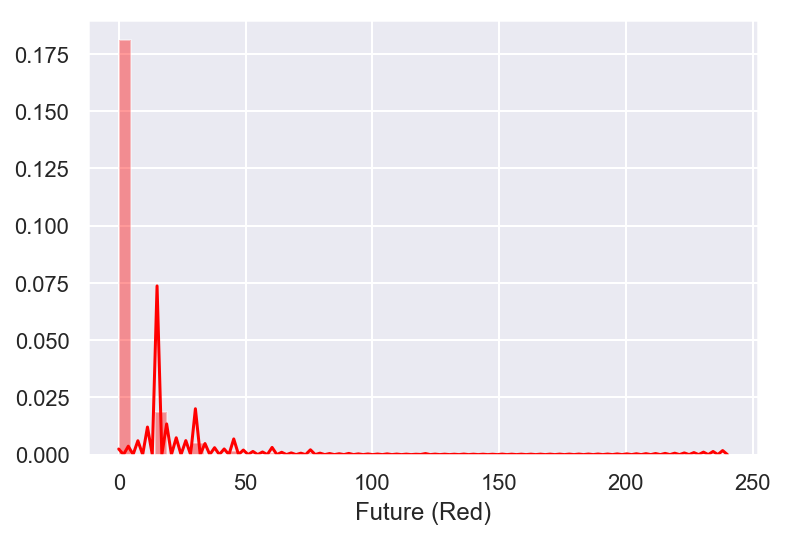

In [44]:
sns.distplot(temp_f, axlabel='Future (Red)', color='red');

In [45]:
sns.distplot(temp_p, axlabel='Past (Green)', color='green');

In [46]:
sns.distplot(temp_n, axlabel='Now (Blue)', color='blue');

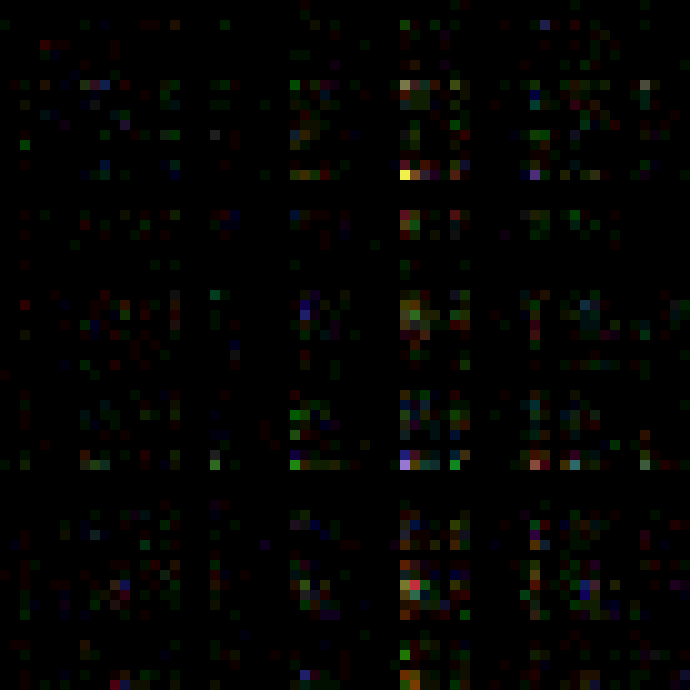

In [47]:
first_snapshot = first_snapshot.astype('uint8')
first_image = Image.fromarray(first_snapshot)
first_image.resize((690,690))

In [48]:
# image save directory:
img_path = r'D:\GITHUB\GSPNet\snapshots'

# save image
# first_image.save(f'{img_path}\\1.jpg')
# first_image.resize((690,690)) # multiply by factor of 100

### Put above codes into a function:

In [ ]:
# Function that combines layers to an image
def gen_image(p_layer, n_layer, f_layer):
    '''
    Generate an image using given matrices.
    Params:
        p_layer: matrix of past layer
        n_layer: matrix of now layer
        f_layer: matrix of future layer
    Return:
        A PIL image.
    '''
    # create a snapshot
    snapshot = np.zeros([img_size, img_size, 3], dtype='float64')

    # unexpected zones
    left_zones = set()

    # future-Red: 0
    for _, row in f_layer.iterrows():
        try:
            snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 0] += 1
        except Exception as e:
            left_zones.add(str(row['pulocationid']))
            left_zones.add(str(row['dolocationid']))

    # past-Green: 1
    for _, row in p_layer.iterrows():
        try:
            snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 1] += 1
        except Exception as e:
            left_zones.add(str(row['pulocationid']))
            left_zones.add(str(row['dolocationid']))

    # now-Blue: 2
    for _, row in n_layer.iterrows():
        try:
            snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 2] += 1
        except Exception as e:
            left_zones.add(str(row['pulocationid']))
            left_zones.add(str(row['dolocationid']))

    # normalize
    snapshot *= 255 // snapshot.max()
    snapshot = snapshot.astype('uint8')
    image = Image.fromarray(snapshot)
    return image

# generate tensor, because saving image as intermediate data is not efficient
def gen_tensor(p_layer, n_layer, f_layer):
    '''
    Generate a tensor using given matrices.
    Params:
        p_layer: matrix of past layer
        n_layer: matrix of now layer
        f_layer: matrix of future layer
    Return:
        A torch tensor.
    '''
    # create a snapshot
    snapshot = np.zeros([img_size, img_size, 3], dtype='float64')

    # unexpected zones
    left_zones = set()

    # future-Red: 0
    for _, row in f_layer.iterrows():
        try:
            snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 0] += 1
        except Exception as e:
            left_zones.add(str(row['pulocationid']))
            left_zones.add(str(row['dolocationid']))

    # past-Green: 1
    for _, row in p_layer.iterrows():
        try:
            snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 1] += 1
        except Exception as e:
            left_zones.add(str(row['pulocationid']))
            left_zones.add(str(row['dolocationid']))

    # now-Blue: 2
    for _, row in n_layer.iterrows():
        try:
            snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 2] += 1
        except Exception as e:
            left_zones.add(str(row['pulocationid']))
            left_zones.add(str(row['dolocationid']))

    # normalize
    snapshot *= 255 // snapshot.max()
    snapshot = torch.from_numpy(snapshot)
    return snapshot

In [ ]:
# Function that gets a specific layer of snapshot.
def get_channel(image, layer:str):
    '''
    Get a layer of the snapshot.
    Params:
        image: PIL image
        channel: one of R-F,G-P,B-N
    Return:
        single channel image
    '''
    assert layer in ['P', 'N', 'F']
    namedict = {'P': 'G', 'N': 'B', 'F': 'R'}
    chandict = {'R':0, 'G':1, 'B':2}
    template = np.array(image)
    chan = np.zeros([*template.shape], dtype='uint8')
    chan[:,:,chandict[namedict[layer]]] = image.getchannel(namedict[layer])
    chan = Image.fromarray(chan)
    return chan

In [ ]:
# future layer
# first_image.getchannel('R').resize((345,345))
red = get_channel(first_image, 'F')
red = red.resize((345,345))
red_bright = first_image.getchannel('R').resize((345,345))

display(red, red_bright)

In [ ]:
# Past layer
green = get_channel(first_image, 'P')
green = green.resize((345,345))

# Past layer (green) in brightness.
green_bright = first_image.getchannel('G').resize((345,345))
display(green, green_bright)

In [ ]:
# Now layer
# first_image.getchannel('B').resize((345,345))
blue = get_channel(first_image, 'N')
blue = blue.resize((345,345))

# Now layer (blue) in brightness.
blue_bright = first_image.getchannel('B').resize((345,345))

display(blue, blue_bright)

### Using the above procedure, all 4464 tensors can be generated.

**Possible variations:**
+ Weight the value with passenger number
+ Design a method to achieve finer granularity to distinguish trips with much longer time (3X std.)

### 6. Parallel Batch Image Generation

Now let's define a batch processing function to generate tonsors like above according to time interval. For the sake of effitiency, parallel boost is used (i.e. dask). The **computation graphs** of the generator is as follows:

<img src="images/flowgraph_imggen.png" align="left" width="70%">

#### Individual functions:

Create a list of time bounds given the starting point and ending point of a time interval:

In [ ]:
def timesplit(stp: str, etp: str, freq='10min'):
    '''
    Create a DatetimeIndx interval.
    
    Params:
        stp: string, starting time point, first left bound
        etp: string, ending time point, last right bound
        freq: frequency, time interval unit of the splice operation
    The stp and etp must of pattern "yyyy-mm-dd hh:mm:ss", otherwise exception will be raised.
    
    Return:
        A list of time intervals tuples,each item is a tuple of two
        interval(i.e., pandas.core.indexes.datetimes.DatetimeIndex object)
        For example, a possible return could be [(2017-01-01 00:00:00, 2017-01-01 00:10:00),
                                                 (2017-01-01 00:10:00, 2017-01-01 00:20:00)]
    '''
    pattern = re.compile('^([0-9]{4})-([0-1][0-9])-([0-3][0-9])\s([0-1][0-9]|[2][0-3]):([0-5][0-9]):([0-5][0-9])$')
    if pattern.match(stp) and pattern.match(etp):
        time_bounds = pd.date_range(stp, etp, freq=freq)
        sub_intervals = list(zip(time_bounds[:-1], time_bounds[1:]))
        print(len(time_bounds), len(sub_intervals))
        return sub_intervals
    else:
        raise Exception('Provided time bound is of invalid format.')


In [ ]:
timelist = timesplit('2017-01-01 00:00:00', '2017-02-01 00:00:00')

In [ ]:
# Number of characters needed to save a time pair
sum(list(map(len, ['2017-01-01 00:00:00', '2017-02-01 00:00:00'])))

In [ ]:
# test functions
timelist = timesplit('2017-01-01 00:00:00', '2017-02-01 00:00:00')
print(f'timelist length: {len(timelist)}')

bound = timelist[100]
print(type(bound))
print(bound[0])
print(bound[1])

f_player, f_nlayer, f_flayer = gen_snap_layers(table, bound)
image = gen_image(f_player, f_nlayer, f_flayer)

# image save directory:
visual_path = r'D:\GITHUB\GSPNet\snapshots\visualization'
data_path = r'D:\GITHUB\GSPNet\snapshots\data'

# save image
image.save(f'{data_path}\\d1.bmp')
vimage = image.resize((690,690)) # multiply by factor of 100
vimage.save(f'{visual_path}\\v1.bmp')
vimage

In [ ]:
rdtbt = time.time()
timelist = timesplit('2017-02-01 00:00:00', '2017-03-01 00:00:00')
table = pd.read_csv('dataset/nytaxi_yellow_2017_feb.csv')
print(f'data loaded in {time.time() - rdtbt}')

In [ ]:
table.head()

In [ ]:
start = time.time()
# convert dtype for entire table here:
table['tpep_pickup_datetime'] = pd.to_datetime(table['tpep_pickup_datetime'])
table['tpep_dropoff_datetime'] = pd.to_datetime(table['tpep_dropoff_datetime'])
for i, bound in enumerate(timelist):
    p_layer, n_layer, f_layer = gen_snap_layers(table, bound)
    tensor = gen_tensor(p_layer, n_layer, f_layer)
    torch.save(tensor, f'{data_path}\\nytaxi_yellow_2017_feb_d{i}.pt')
    image = gen_image(p_layer, n_layer, f_layer)
    vimage = image.resize((690,690)) # multiply by factor of 100
    vimage.save(f'{visual_path}\\nytaxi_yellow_2017_feb_v{i}.jpg')
print(f'Image and tensor generation done in {time.time() - start :.2f} seconds.')

In [ ]:
26155 / 60 / 60

## Part 2: Modeling

## Part 3: Prediction & per demand modification of states (to be done)